In [1]:
# Import necessary libraries
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Function to load lab file
def load_lab_file(path):
    # Load the .mat file
    mat = scipy.io.loadmat(path)
    # Extract the sample rate
    f_s = mat['samplerate'][0][0]
    # Extract the start and end indices of each comment
    comment_starts = mat['datastart']
    comment_ends = mat['dataend']
    # Extract the recorded signals
    recorded_signals = np.array(mat['data'])[0,:]
    # Extract the label names and add 'Rest' as the first label
    label_names = mat['comtext'].tolist()
    label_names.insert(0,'Rest')
    # Define the muscle names
    muscle_names = ["Biceps", "Triceps"]
    # Initialize a dictionary to hold the signals for each muscle
    signals_dict = {}
    # Loop over each muscle
    for i in range(2, len(comment_starts)):
        # Initialize a dictionary to hold the signals for each label
        muscle_dict = {}
        # Loop over each label
        for j in range(len(comment_starts[i])):
            # If the label is not 'New Comment', add the signal to the dictionary
            if label_names[j]!="New Comment":
                muscle_dict[label_names[j]] = recorded_signals[int(comment_starts[i][j]):int(comment_ends[i][j])]
        # Add the muscle dictionary to the signals dictionary
        signals_dict[muscle_names[i-2]] = muscle_dict
    # Return the signals dictionary, label names, muscle names, and sample rate
    return signals_dict, label_names, muscle_names, f_s

# Load the lab file
signals_dict, label_names, muscle_names, f_s = load_lab_file('/content/FINAL LAB2.mat')

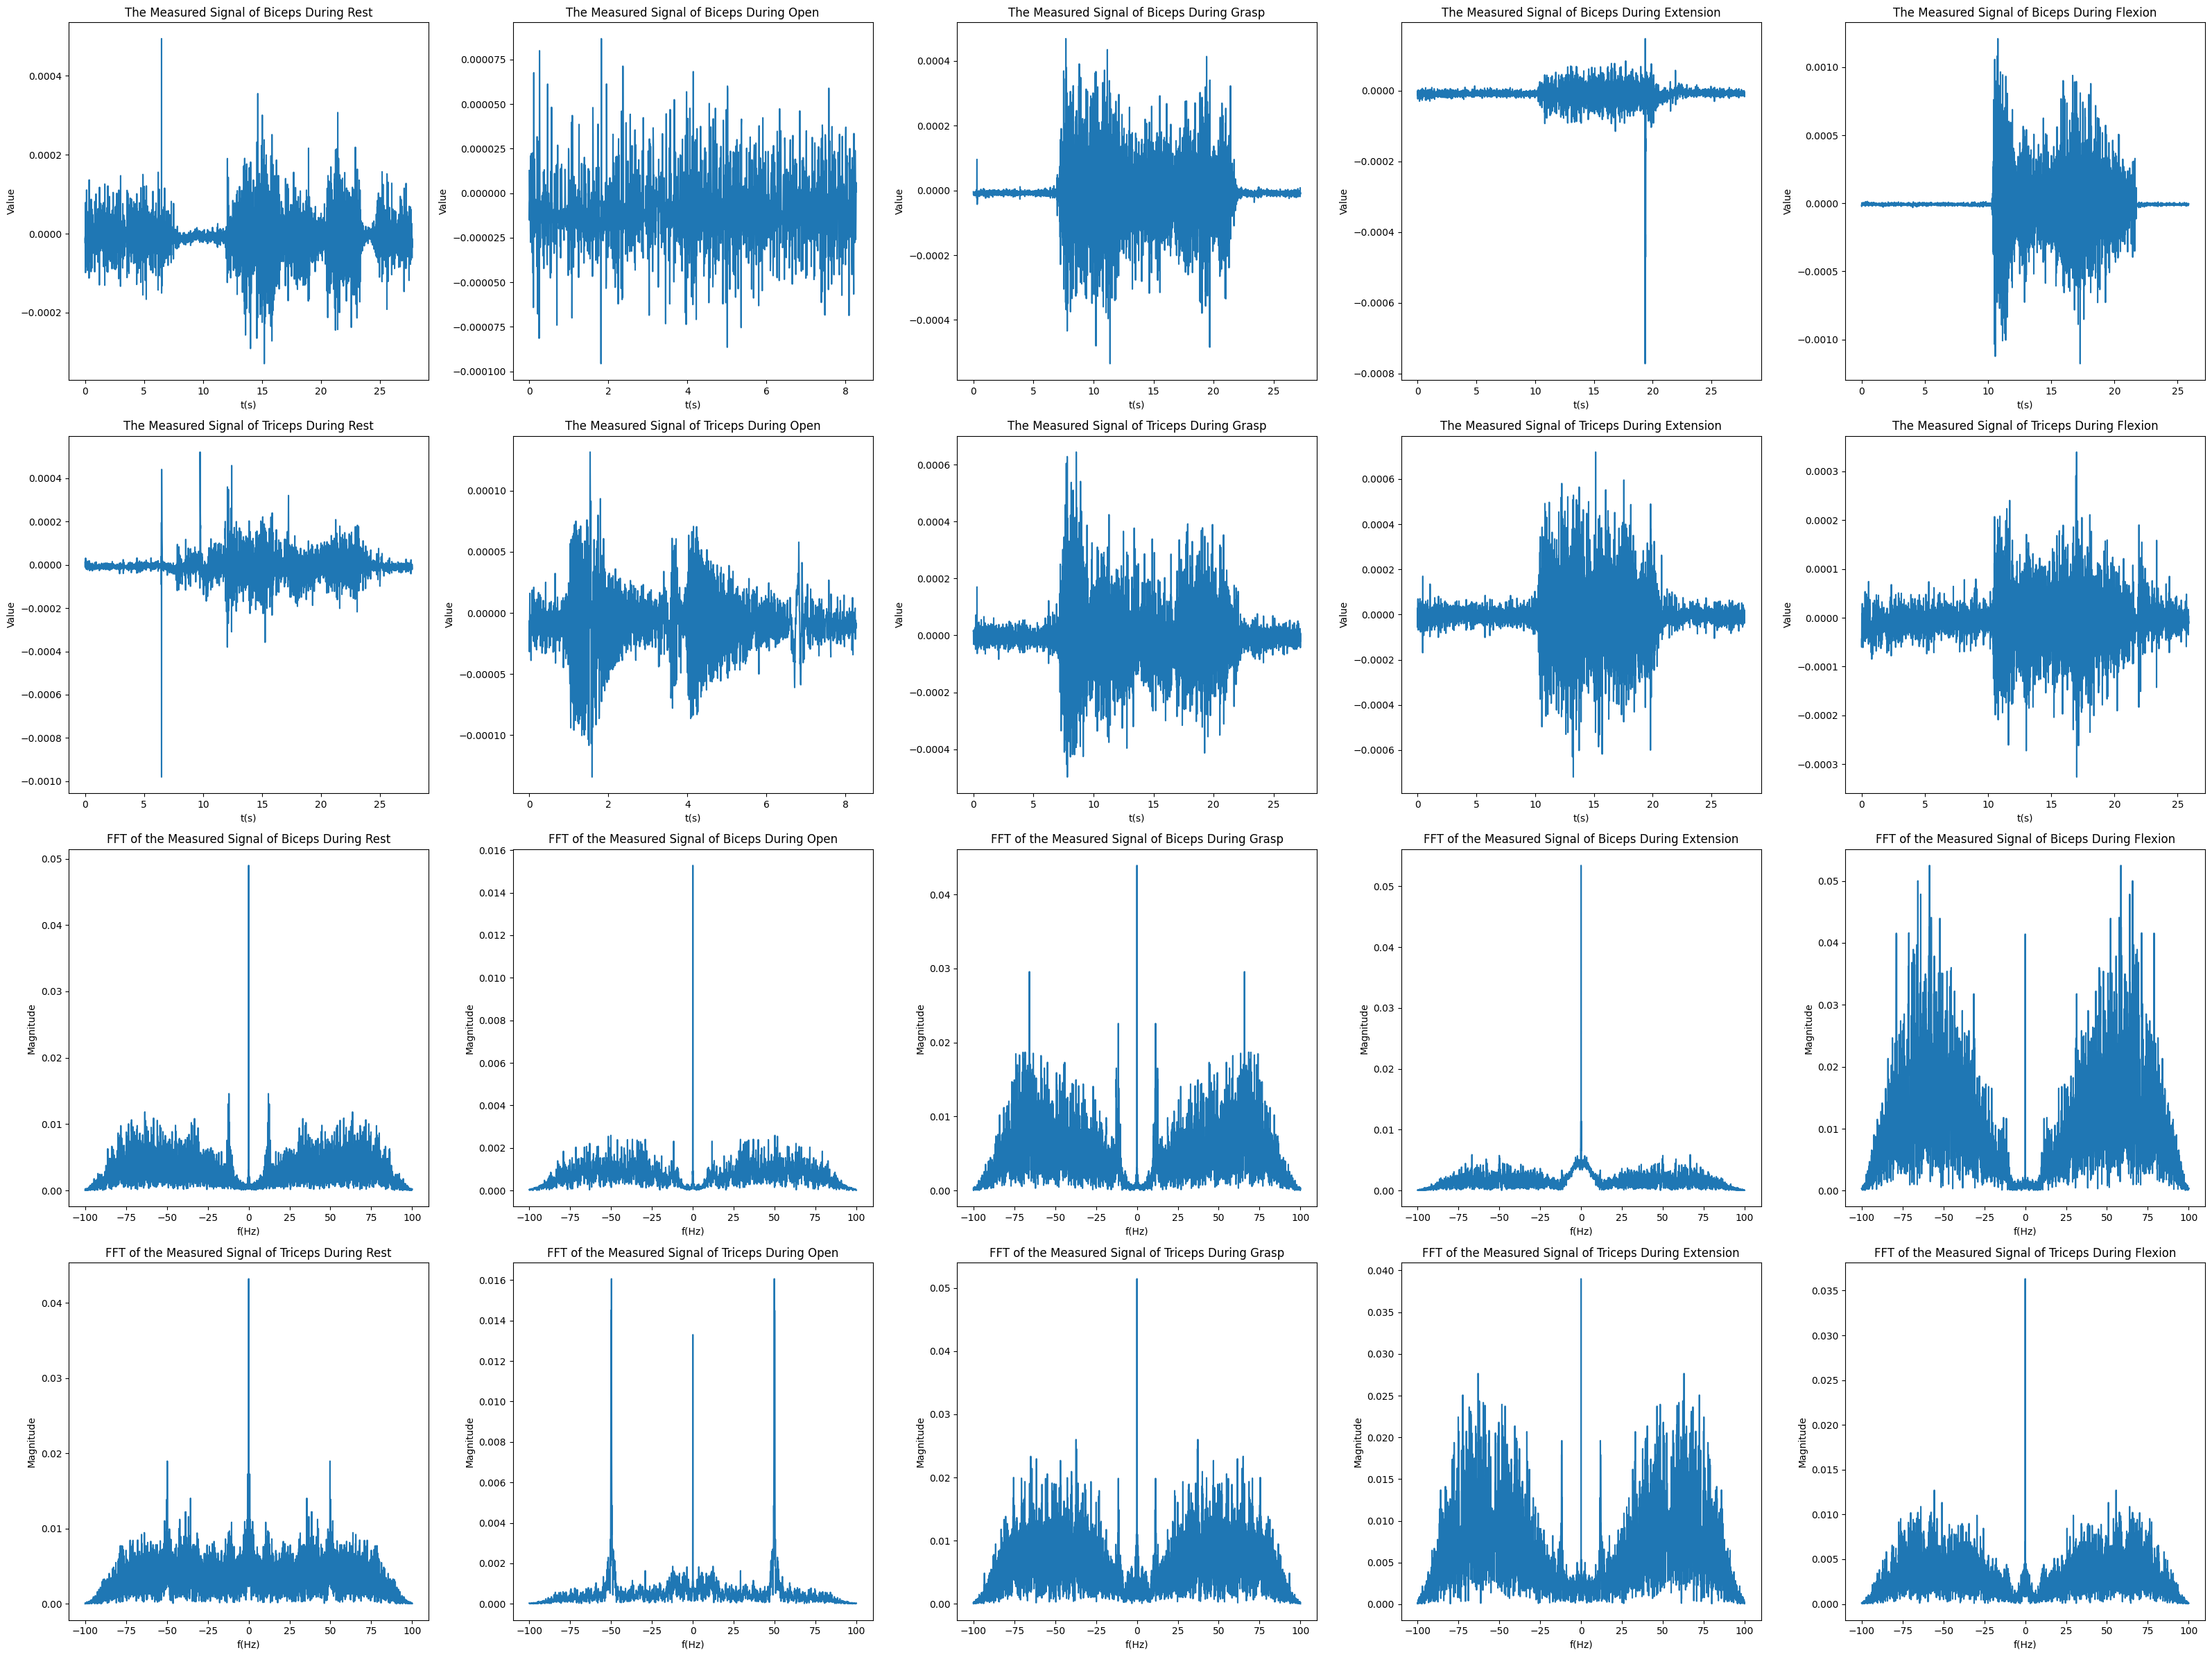

In [6]:
# Define a dictionary to map the original labels to new labels
labels_dict = {'Rest': 'Rest', 'open     ': 'Open', 'grasp    ': 'Grasp', 'extension': 'Extension', 'flexion  ': 'Flexion'}

# Function to show signals
def show_signals(signals_dict, label_names, muscle_names, f_s):
    # Create a figure with subplots for each muscle and label
    fig, axs = plt.subplots(2*len(signals_dict), len(signals_dict[muscle_names[0]]), figsize=(32,24))
    # Loop over each muscle
    for i, muscle_key in enumerate(muscle_names):
        # Loop over each label
        for j, signal_key in enumerate(signals_dict[muscle_key].keys()):
            # Extract the signal
            signal = signals_dict[muscle_key][signal_key]
            # Create a time array
            t = np.linspace(0, (len(signal)-1)/f_s, len(signal))
            # Create a frequency array
            f = np.linspace(-f_s/2, f_s/2, len(signal))
            # Calculate the FFT of the signal
            signal_fft = np.fft.fftshift(np.fft.fft(signal))
            # Plot the signal
            axs[i, j].plot(t, signal)
            axs[i, j].set_title(f'The Measured Signal of {muscle_key} During {labels_dict[signal_key]}')
            axs[i, j].set_xlabel('t(s)')
            axs[i, j].set_ylabel('Value')
            # Plot the FFT of the signal
            axs[i+2, j].plot(f, np.abs(signal_fft))
            axs[i+2, j].set_title(f'FFT of the Measured Signal of {muscle_key} During {labels_dict[signal_key]}')
            axs[i+2, j].set_xlabel('f(Hz)')
            axs[i+2, j].set_ylabel('Magnitude')
    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.savefig("before filter.jpg")

# Show the signals
show_signals(signals_dict, label_names, muscle_names, f_s)

In [4]:
# Import necessary libraries
from scipy.signal import butter, lfilter

# Function to design a Butterworth lowpass filter
def butter_lowpass(cutoff, f_s=200, order=1):
    # Calculate the Nyquist frequency
    nyq = 0.5 * f_s
    # Normalize the cutoff frequency by the Nyquist frequency
    normal_cutoff = cutoff / nyq
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Function to apply a Butterworth lowpass filter to a signal
def butter_lowpass_filter(data, cutoff, f_s, order=1):
    # Design the filter
    b, a = butter_lowpass(cutoff, f_s, order=order)
    # Apply the filter to the data
    y = lfilter(b, a, data)
    return y

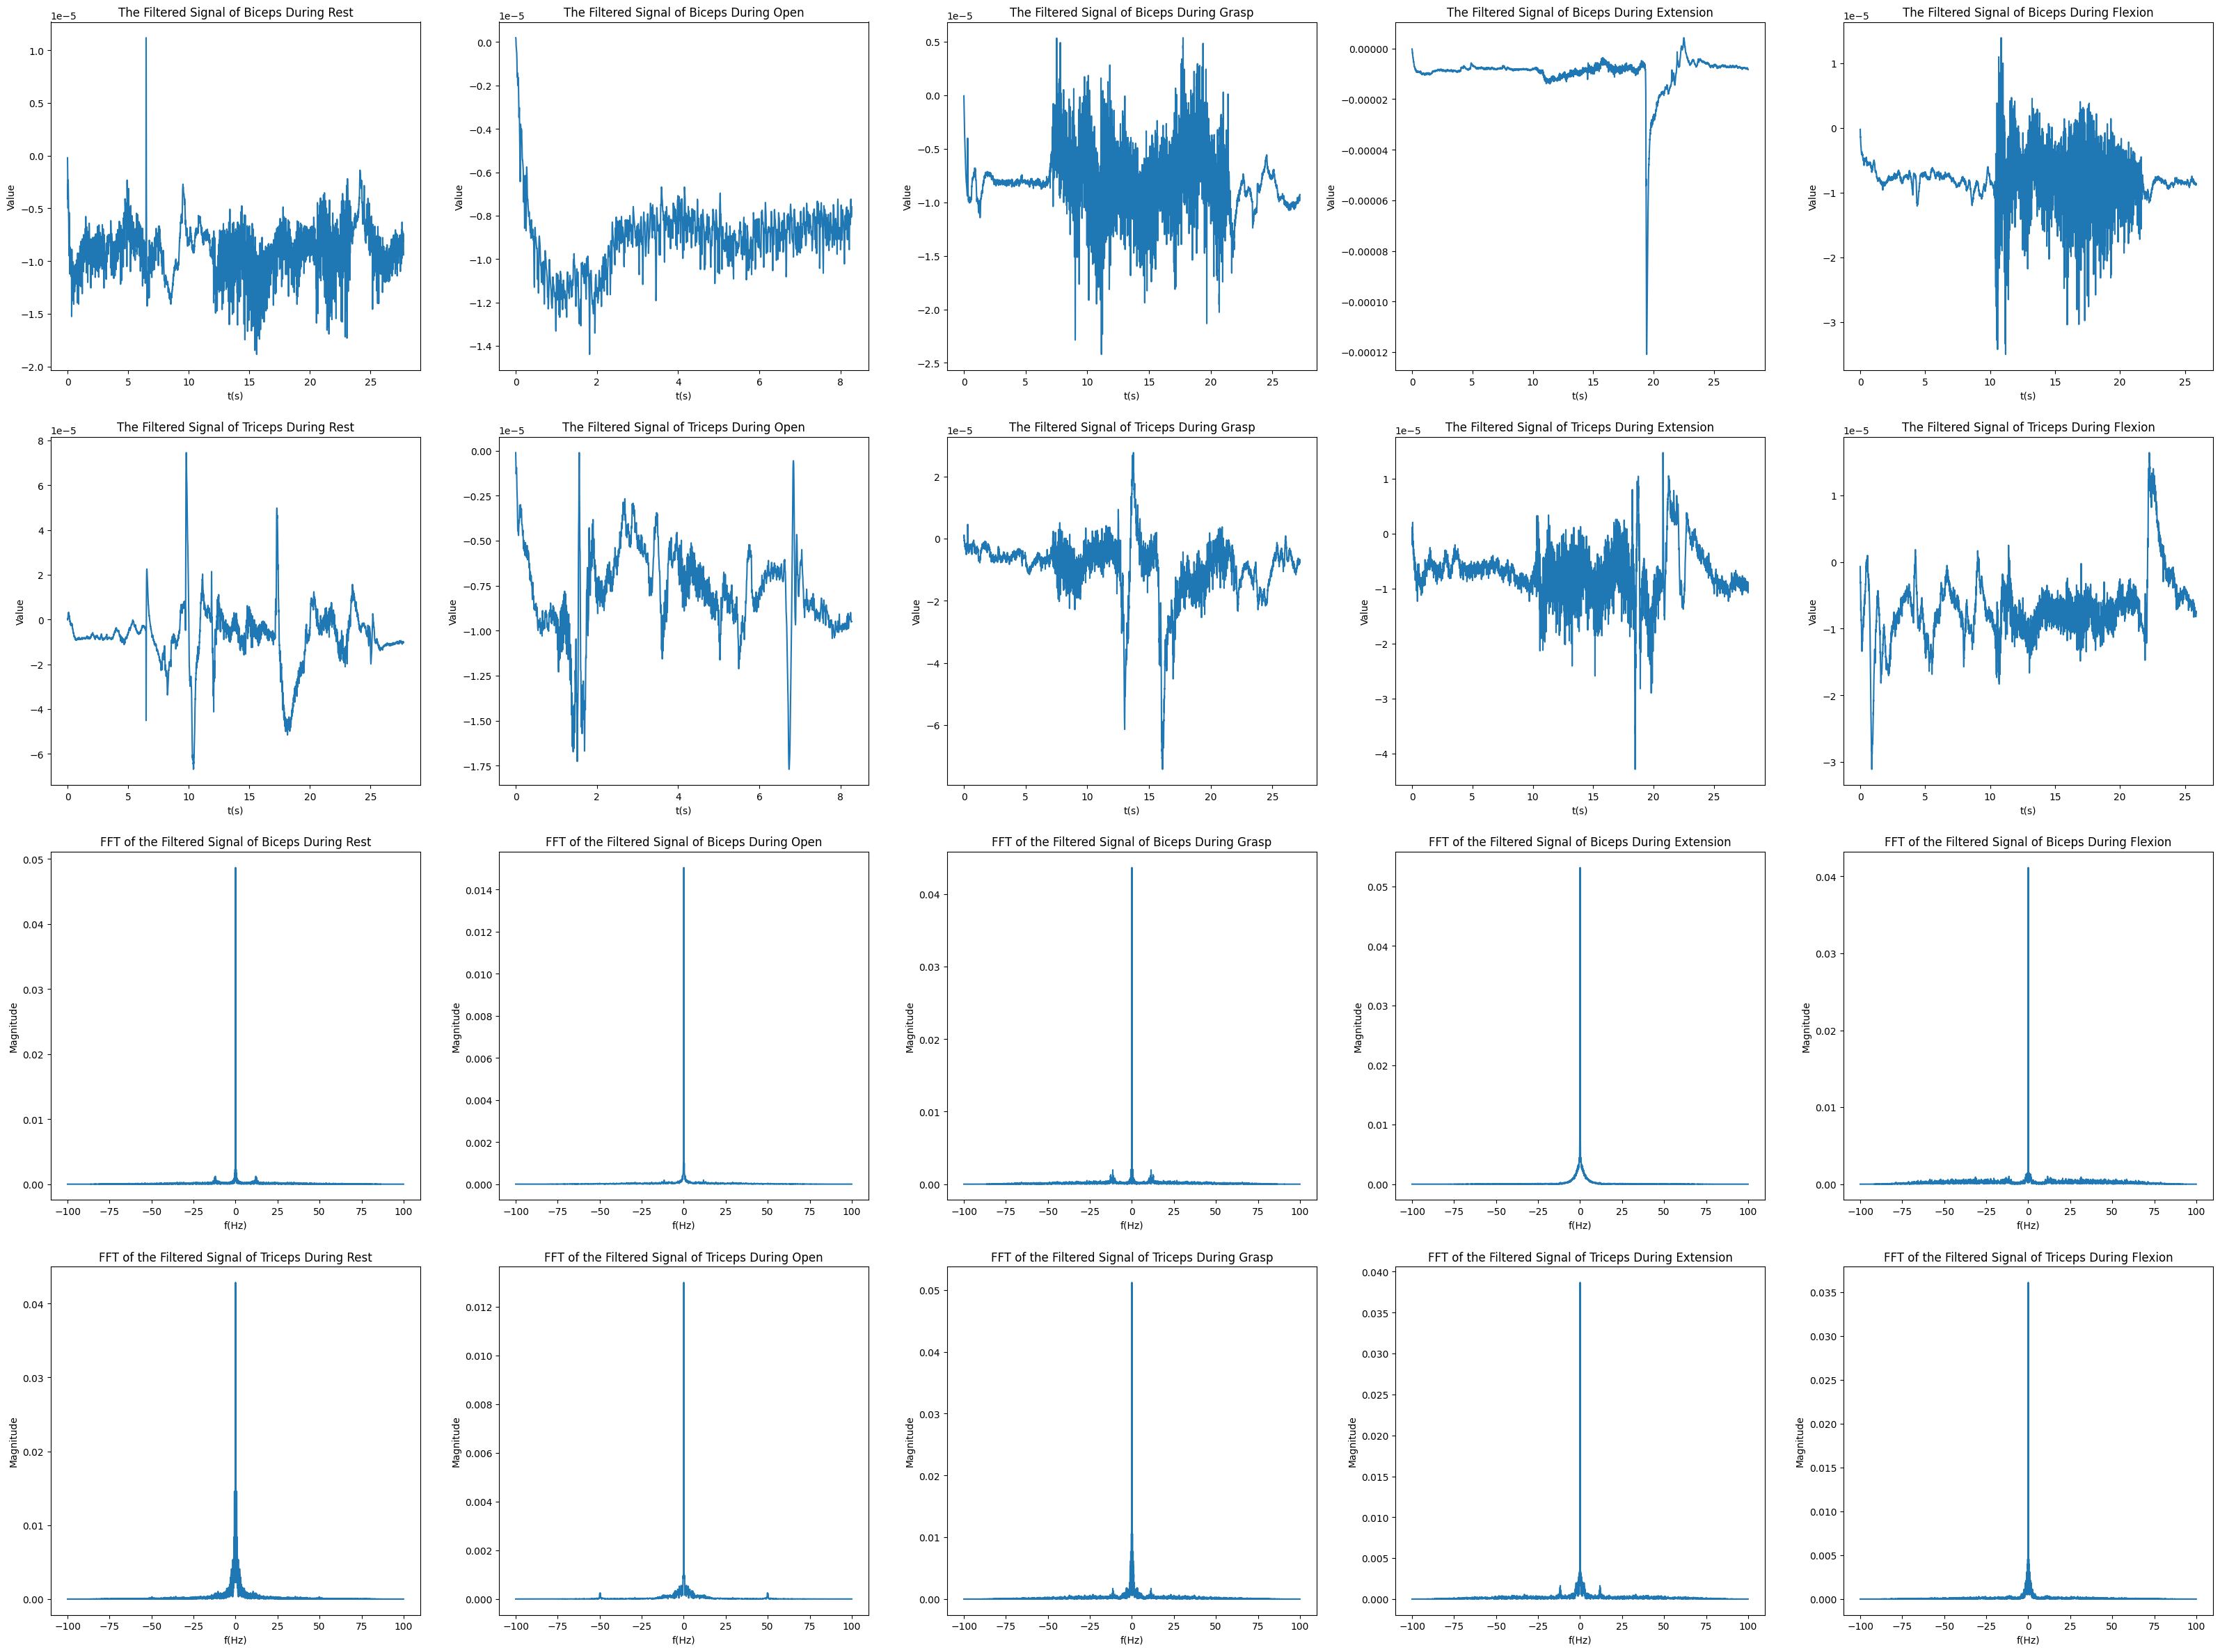

In [7]:
# Function to filter signals and plot the filtered signals
def filter_and_show_filtered_signals(signals_dict, label_names, muscle_names, f_s):
    # Initialize a dictionary to hold the filtered signals
    filtered_dict = {}
    # Create a figure with subplots for each muscle and label
    fig, axs = plt.subplots(2*len(signals_dict), len(signals_dict[muscle_names[0]]), figsize=(32,24))
    # Loop over each muscle
    for i, muscle_key in enumerate(muscle_names):
        # Initialize a dictionary to hold the filtered signals for each label
        filter_dict = {}
        # Loop over each label
        for j, signal_key in enumerate(signals_dict[muscle_key].keys()):
            # Filter the signal
            signal = butter_lowpass_filter(signals_dict[muscle_key][signal_key], 1, f_s)
            # Add the filtered signal to the dictionary
            filter_dict[signal_key] = signal
            # Create a time array
            t = np.linspace(0, (len(signal)-1)/f_s, len(signal))
            # Create a frequency array
            f = np.linspace(-f_s/2, f_s/2, len(signal))
            # Calculate the FFT of the signal
            signal_fft = np.fft.fftshift(np.fft.fft(signal))
            # Plot the filtered signal
            axs[i, j].plot(t, signal)
            axs[i, j].set_title(f'The Filtered Signal of {muscle_key} During {labels_dict[signal_key]}')
            axs[i, j].set_xlabel('t(s)')
            axs[i, j].set_ylabel('Value')
            # Plot the FFT of the filtered signal
            axs[i+2, j].plot(f, np.abs(signal_fft))
            axs[i+2, j].set_title(f'FFT of the Filtered Signal of {muscle_key} During {labels_dict[signal_key]}')
            axs[i+2, j].set_xlabel('f(Hz)')
            axs[i+2, j].set_ylabel('Magnitude')
        # Add the dictionary of filtered signals for this muscle to the main dictionary
        filtered_dict[muscle_key] = filter_dict
    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.savefig("after filter.jpg")
    # Return the dictionary of filtered signals
    return filtered_dict

# Filter the signals and show the filtered signals
filtered_dict = filter_and_show_filtered_signals(signals_dict, label_names, muscle_names, f_s)

In [8]:
# Function to calculate Mean Absolute Value (MAV) of a window
def get_MAV(window):
    return np.mean(np.abs(window), axis=1)

# Function to calculate Standard Deviation (STD) of a window
def get_STD(window):
    n = window.shape[1]
    return np.sqrt(np.std(np.abs(window), axis=1)**2*n/(n-1))

# Function to calculate Variance (VAR) of a window
def get_VAR(window):
    n = window.shape[1]
    w2 = window**2
    return np.mean(w2, axis=1)*n/(n-1)

# Function to calculate Waveform Length (WL) of a window
def get_WL(window):
    return np.sum(np.abs(np.diff(window, axis=1)), axis=1)

# Function to calculate Zero Crossings (ZC) of a window
def get_ZC(window):
    return np.sum(np.multiply(window[:, :-1], window[:, 1:]) < 0 , axis=1)

# Function to calculate Root Mean Square (RMS) of a window
def get_RMS(window):
    w2 = window**2
    return np.sqrt(np.mean(w2, axis=1))

# Function to calculate Number of Peaks (NP) of a window
def get_NP(window, RMS):
    return np.sum(window > RMS[:, np.newaxis], axis=1)

# Function to calculate Slope Sign Changes (SSC) of a window
def get_SSC(window, thres):
    return np.sum(np.multiply(np.diff(window, axis=1)[:, :-1], np.diff(window, axis=1)[:, 1:]) > thres , axis=1)

# Function to calculate Integral Absolute Value (IAV) of a window
def get_IAV(window):
    return np.sum(np.abs(window), axis=1)

In [9]:
# Define a dictionary to map label names to numerical values
labels_dict1 = {'Rest': 0, 'open     ': 1, 'grasp    ': 2, 'extension': 3, 'flexion  ': 4}

# Function to create a dataset from signal data
def create_dataset(signals_dict, label_names, muscle_names, f_s=200, window_size=100, overlap=30):
    # Initialize arrays to hold the features and labels
    features = np.array([])
    labels = np.array([])
    # Loop over each key in the signals dictionary
    for j, signal_key in enumerate(signals_dict[muscle_names[0]].keys()):
        # Extract the signal for each muscle
        signal1 = signals_dict[muscle_names[0]][signal_key]
        signal2 = signals_dict[muscle_names[1]][signal_key]
        # Create windows from the signals
        windows1 = np.array([signal1[i:i+window_size] for i in range(0, len(signal1) - window_size, window_size - overlap)])
        windows2 = np.array([signal2[i:i+window_size] for i in range(0, len(signal2) - window_size, window_size - overlap)])
        # Calculate features from the windows
        feat = np.array([get_MAV(windows1), get_STD(windows1), get_VAR(windows1), get_WL(windows1), get_ZC(windows1), get_RMS(windows1), get_NP(windows1, get_RMS(windows1)), get_SSC(windows1, 0), get_IAV(windows1),
                             get_MAV(windows2), get_STD(windows2), get_VAR(windows2), get_WL(windows2), get_ZC(windows2), get_RMS(windows2), get_NP(windows2, get_RMS(windows2)), get_SSC(windows2, 0), get_IAV(windows2),
                             np.array([np.corrcoef(windows1[i], windows2[i])[0, 1] for i in range(windows1.shape[0])])])
        # Add the features to the features array
        if features.shape[0]==0:
            features = feat
        else:
            features = np.hstack((features, feat))
        # Create labels for each window
        lab = np.array([labels_dict1[signal_key] for _ in range(windows1.shape[0])])
        # Add the labels to the labels array
        labels = np.concatenate((labels, lab))
    # Return the features and labels
    return features.T, labels

# Create a dataset from the filtered signals
X, Y = create_dataset(filtered_dict, label_names, muscle_names, f_s=200, window_size=40, overlap=38)

In [10]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
# The test set size is 20% of the total data
# The data is shuffled before splitting
# The random state ensures that the splits are reproducible
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=0)

# Create a StandardScaler object
# This will be used to standard scale the data (mean = 0, standard deviation = 1)
standard_scaler = StandardScaler()

# Standard scale the training data
# The scaler is fitted to the training data and then used to transform it
X_train_standard_scaled = standard_scaler.fit_transform(X_train)

# Standard scale the testing data
# The scaler is not fitted to the testing data
# Instead, it uses the mean and standard deviation calculated from the training data
X_test_standard_scaled = standard_scaler.transform(X_test)

Test Accuracy for KNN Classifier: 0.9388


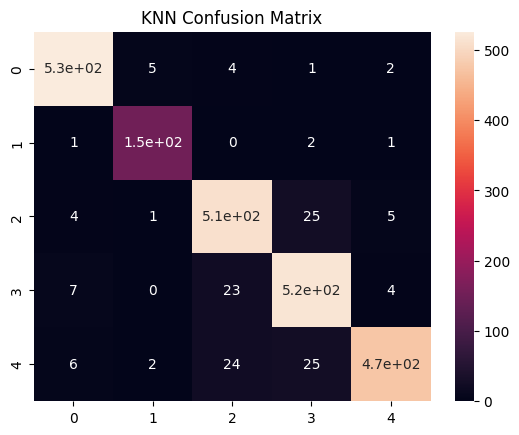

In [13]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Create a K-Nearest Neighbors (KNN) classifier with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the KNN classifier to the standard scaled training data
knn.fit(X_train_standard_scaled, Y_train)

# Use the fitted KNN classifier to predict the labels for the standard scaled test data
Y_predict = knn.predict(X_test_standard_scaled)

# Compute the confusion matrix between the true and predicted labels for the test data
cf_matrix = confusion_matrix(Y_test, Y_predict)

# Use seaborn to create a heatmap visualization of the confusion matrix
sns.heatmap(cf_matrix, annot=True)

# Set the title for the heatmap
plt.title('KNN Confusion Matrix')
plt.savefig("KNN.jpg")

# Calculate and print the accuracy of the KNN classifier on the test data
print(f"Test Accuracy for KNN Classifier: {accuracy_score(Y_predict, Y_test):.4f}")

Test Accuracy for Random Forest Classifier: 0.9935


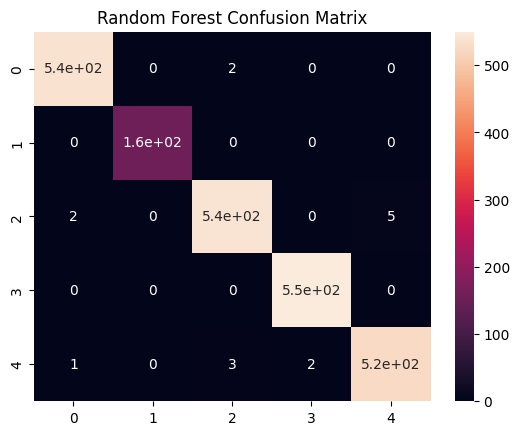

In [14]:
# Import necessary library
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier with 100 trees and a fixed random state for reproducibility
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest classifier to the standard scaled training data
rf.fit(X_train_standard_scaled, Y_train)

# Use the fitted Random Forest classifier to predict the labels for the standard scaled test data
Y_predict = rf.predict(X_test_standard_scaled)

# Compute the confusion matrix between the true and predicted labels for the test data
cf_matrix = confusion_matrix(Y_test, Y_predict)

# Use seaborn to create a heatmap visualization of the confusion matrix
sns.heatmap(cf_matrix, annot=True)

# Set the title for the heatmap
plt.title('Random Forest Confusion Matrix')
plt.savefig("Random Forest.jpg")

# Calculate and print the accuracy of the Random Forest classifier on the test data
print(f"Test Accuracy for Random Forest Classifier: {accuracy_score(Y_predict, Y_test):.4f}")